In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns

import openeo
#import ee
# Trigger the authentication flow.
#ee.Authenticate()
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [174]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def make_input_array(self):
        ## Puts pandas phenological frame into driver xarray and aligns the two
        just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
        x_coords = just_emergence_phen_data['lon'].values
        y_coords = just_emergence_phen_data['lat'].values
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_coords, y_coords)
        print('interpolate driver to station locations')
        # Working in xarray (not pandas) after this point:
        self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
        self.GDD_driver_data['Stations_id'] = (("modelpoint"), np.int64(just_emergence_phen_data['Stations_id'].values))
        self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), np.int64(just_emergence_phen_data['Referenzjahr'].values))
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
        ## Get times to be indexed from emergence day start at emergence day for every site ##
        self.index_time_from_emergence_day()
        self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        if type(self.GDD_driver_data) == str:
            print('Make a dataset for the driving variable first')
        else:
            t_dev = np.zeros(self.GDD_driver_data[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
            dev_time_series = [t_dev.copy()]
            for day in range(365):
                driver_values = self.GDD_driver_data.isel(time=day)[driver_variable].values 
                t_dev += response(driver_values, t_dev)
                dev_time_series.append(t_dev.copy())
            self.model_dev_time_series = np.array(dev_time_series)
            self.GDD_driver_data['Development Time'] = (('days from emergence', 'modelpoint'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    
    def get_modelled_dataset(self, phase_list = []):
        if len(phase_list) == 0:
            computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
        else:
            computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
            #Initialize dataset for comparison with station IDs and years
        data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                        }
        self.ds_comparison = pd.DataFrame(data_comparison)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(computed_phases):
            self.ds_comparison[phase] = self.phase_dates_array[phase_index, :]
        self.ds_comparison.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, phase_list, winter_sowing = False):
        observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase_list[0], winter_sowing=winter_sowing).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
        for phase in phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
        self.ds_observed = self.ds_observed.reset_index()
        self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.concat([self.ds_comparison, self.ds_observed], axis = 1)

    ## Functions for ML ##    
    def put_obs_data_in_input_array(self): #, predictor_days = 200
        y_data = {}
        for phase_time in self.ds_observed.columns:
            if phase_time != 'lat' and phase_time != 'lon':
                y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
        #print(y_data)
        obs_data = xr.Dataset(data_vars = y_data,
                                coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                        'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                        )
        #print(obs_data)
        obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
        #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
        #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
        self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
        self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')
        
    def get_X_y_for_ML(self, driver_variable, predictor_days = 200, cumulative = False, thinning_parameter = 1):
        self.X_for_ML = self.GDD_driver_data[driver_variable][:predictor_days, :].values.T
        if cumulative:
            self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
        if thinning_parameter != 1:
            self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
        self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    
    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, phase_list, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7380\2927766938.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [112]:
#Maize_set.ds_ML_results.where(Maize_set.ds_ML_results['Training'] ==True).dropna()
#Maize_set.ds_ML_results.where(Maize_set.ds_ML_results['Training'] ==True).dropna().drop_duplicates()
Maize_set.ds_ML_predictions_training.drop_duplicates()
#Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True).dropna()

,Stations_id,Referenzjahr,Training,ML prediction emergence to beginning of flowering,ML check obs to beginning of flowering,ML prediction emergence to yellow ripeness,ML check obs to yellow ripeness
0,10461,2011,True,76.833333,81.0,125.333333,124.0
1,10487,2017,True,62.000000,62.0,98.000000,98.0
2,13584,2006,True,73.000000,73.0,111.000000,111.0
3,10176,2021,True,71.375000,73.0,107.375000,120.0
4,13372,2005,True,61.400000,61.0,120.400000,121.0
...,...,...,...,...,...,...,...
6341,11396,2017,True,69.000000,69.0,107.000000,107.0
6342,12162,2015,True,79.294118,92.0,134.029412,136.0
6345,8135,2006,True,76.000000,76.0,125.000000,125.0
6356,9732,2007,True,91.000000,91.0,141.000000,141.0


In [170]:
Maize_set.ds_observed

observed time emergence to beginning of flowering  \
Referenzjahr Stations_id                                                      
1951         7617                                                      29.0   
             7899                                                      80.0   
             8137                                                      50.0   
             8191                                                      54.0   
             8234                                                      98.0   
...                                                                     ...   
2022         19488                                                     63.0   
             19554                                                     83.0   
             19585                                                     70.0   
             19587                                                     60.0   
             19914                                                     57.0   

                          observed time emergence to yellow ripeness      lat  \
Referenzjahr Stations_id                                                        
1951         7617                                                NaN  54.6167   
             7899                                                NaN  52.0833   
             8137                                                NaN  52.8667   
             8191                                                NaN  53.2667   
             8234                                                NaN  52.9333   
...                                                              ...      ...   
2022         19488                                             129.0  48.4024   
             19554                                             105.0  53.3222   
             19585                                             128.0  53.6865   
             19587                                               NaN  48.7091   
             19914                                               NaN  50.3168   

                              lon  
Referenzjahr Stations_id           
1951         7617          9.0333  
             7899          9.5667  
             8137          9.6000  
             8191         10.1167  
             8234         11.1167  
...                           ...  
2022         19488        11.6946  
             19554        11.9321  
             19585        11.0608  
             19587         9.2147  
             19914         9.3627  

[27886 rows x 4 columns]

In [86]:
Maize_set.complement_of_subsample.shape

(4813,)

In [175]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()


project to new coords
interpolate driver to station locations


In [ ]:
#Maize_set.GDD_driver_data
#Maize_set.ds_ML_modelled_observed#.dropna(subset = ['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'Training'])#['observed time emergence to beginning of flowering'].dropna()

USE THIS FOR LOOKING AT WHERE ALL THE WHEAT IS
 - https://atlas.thuenen.de/webspace/agraratlas/agraratlas/index.html?LP=1

In [176]:
tp=5
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(['beginning of flowering', 'yellow ripeness'], md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


In [177]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])

In [178]:
print(Maize_set.y_for_ML)
print(tree_rules)

[[ 80. 145.]
 [ 77. 147.]
 [ 83. 126.]
 ...
 [104. 163.]
 [102. 160.]
 [ 73. 126.]]
|--- Day 40 cum. temp <= 650.91
|   |--- Day 185 cum. temp <= 626.21
|   |   |--- Day 195 cum. temp <= 658.45
|   |   |   |--- value: [70.44, 118.79]
|   |   |--- Day 195 cum. temp >  658.45
|   |   |   |--- value: [42.00, 85.00]
|   |--- Day 185 cum. temp >  626.21
|   |   |--- Day 60 cum. temp <= 939.01
|   |   |   |--- value: [80.29, 132.14]
|   |   |--- Day 60 cum. temp >  939.01
|   |   |   |--- value: [73.43, 124.42]
|--- Day 40 cum. temp >  650.91
|   |--- Day 95 cum. temp <= 1747.03
|   |   |--- Day 70 cum. temp <= 1226.87
|   |   |   |--- value: [69.17, 121.48]
|   |   |--- Day 70 cum. temp >  1226.87
|   |   |   |--- value: [64.66, 117.33]
|   |--- Day 95 cum. temp >  1747.03
|   |   |--- Day 70 cum. temp <= 1235.81
|   |   |   |--- value: [59.29, 54.59]
|   |   |--- Day 70 cum. temp >  1235.81
|   |   |   |--- value: [65.36, 109.62]



In [183]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

3595
3595
Phase: beginning of flowering
RMSE for ML is 8.7
RMSE for model is 15.7
RMSE to training mean is 10.1
Phase: yellow ripeness
RMSE for ML is 12.6
RMSE for model is 28.2
RMSE to training mean is 13.4


In [36]:
Maize_set.ds_observed.xs(19732, level=1, drop_level=False)#[:, 19732]#19914]
#Maize_set.ds_observed.xs(1957, level=0, drop_level=False)

NameError: name 'Maize_set' is not defined

In [6]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
# Connect to openEO back-end.
connection = openeo.connect("openeo.dataspace.copernicus.eu/openeo/1.2").authenticate_oidc()

In [41]:
Maize_set.ds_ML_modelled_observed[['lat', 'lon']].values.tolist()[:100][2]
locs_for_datacube =   { "type": "FeatureCollection",
    "features": []
}
for coords in Maize_set.ds_ML_modelled_observed[['lat', 'lon']].values.tolist()[:100]:
    locs_for_datacube["features"].append({"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": coords}})

[54.3167, 10.05]

In [43]:
datacube = connection.load_collection(
  "SENTINEL2_L2A",
  spatial_extent={"west": 5, "south": 47, "east": 16, "north": 56},
  temporal_extent=["2016-01-01", "2016-01-31"],
  bands=["B04", "B08"]
)
locationed = datacube.aggregate_spatial(geometries = locs_for_datacube, reducer = 'mean')
res = locationed.save_result(format = "NetCDF")

In [37]:
print([dataset_info['summary'] for dataset_info in connection.list_processes()[123:]])
print(connection.list_processes()[123])

['One-dimensional linear interpolation for arrays', 'Manipulates dates and times by addition or subtraction', 'Between comparison for dates and times', 'Merge two arrays', 'Create an array', 'Add information to the logs', 'Text begins with another text', 'Text contains another text', 'Text ends with another text', 'Concatenate elements to a single text', 'Loads data from STAC', 'If-Then-Else conditional', 'Export data to a cloud user workspace', 'Normalized difference']
{'categories': ['arrays', 'math', 'math > interpolation'], 'description': 'Performs a linear interpolation for each of the no-data values (`null`) in the array given, except for leading and trailing no-data values.\n\nThe linear interpolants are defined by the array indices or labels (x) and the values in the array (y).', 'examples': [{'arguments': {'data': [None, 1, None, 6, None, -8]}, 'returns': [None, 1, 3.5, 6, -1, -8]}, {'arguments': {'data': [None, 1, None, None]}, 'returns': [None, 1, None, None]}], 'id': 'array

In [ ]:
job = res.execute_batch(title="Sentinel2_practise")

In [47]:
job.get_results().download_files("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd")
Sat_Vars = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\timeseries.nc')
Sat_Vars['B04'].values

[WindowsPath('C:/Users/wlwc1989/Documents/Phenology_Test_Notebooks/phenology_dwd/timeseries.nc'),
 WindowsPath('C:/Users/wlwc1989/Documents/Phenology_Test_Notebooks/phenology_dwd/job-results.json')]

In [19]:
def get_images_after_emergence(Img_Collection, emergence_date, length_of_period = 300):
    end_date = emergence_date + np.timedelta64(length_of_period, 'D')
    Img_Collection = Img_Collection.filterDate(emergence_date, end_date)
    return Img_Collection

In [22]:
S2 = get_images_after_emergence(S2, Maize_set.GDD_driver_data['time'][0][0].values).select('B4', 'B8', 'QA60')

In [23]:
S2.get()

In [10]:
Maize_set.GDD_driver_data['time'][0][0].values

numpy.datetime64('2007-05-02T12:00:00.000000000')

In [36]:
devtime2020 = Maize_set.GDD_driver_data.where((Maize_set.GDD_driver_data['Referenzjahr'] == 2007)*(Maize_set.GDD_driver_data['Stations_id'] == 11193), drop=True)['Development Time']
driver2020 = Maize_set.GDD_driver_data.where((Maize_set.GDD_driver_data['Referenzjahr'] == 2007)*(Maize_set.GDD_driver_data['Stations_id'] == 11193), drop=True)['tas']
realtime2020 = Maize_set.GDD_driver_data.where((Maize_set.GDD_driver_data['Referenzjahr'] == 2007)*(Maize_set.GDD_driver_data['Stations_id'] == 11193), drop=True)['time']

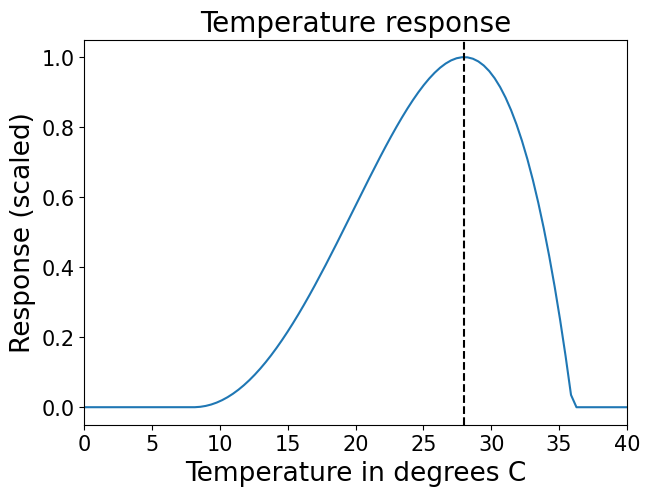

In [186]:
font_size = 19
x = np.linspace(-20, 60, 200)
y = modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)
#y = Trapezoid_Temp_response(x, 0, 21.5, 32.5, 40)
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(x, y)
ax.set_xlabel('Temperature in degrees C', fontsize = font_size)
ax.set_ylabel('Response (scaled)', fontsize = font_size)
ax.set_title('Temperature response', fontsize = font_size + 1)
plt.xticks(fontsize = font_size - 4)
plt.yticks(fontsize = font_size - 4)
ax.set_xlim((0, 40))
ax.axvline(x = 28, linestyle= 'dashed', color = 'black')

Text(0.5, 1.0, 'Temperature compared to development time\nat one station')

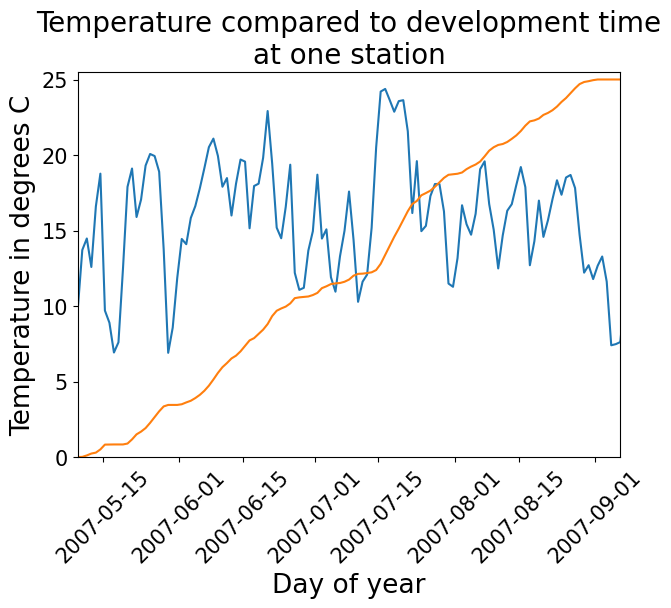

In [51]:
font_size = 19
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(realtime2020, driver2020, label = 'Air temperature at site')
ax.plot(realtime2020, devtime2020*12.5, label = 'Development time (scaled for comparison)')
ax.set_xlim((realtime2020[0], realtime2020[120]))
ax.set_ylim((0, 25.5))
plt.xticks(rotation = 45, fontsize = font_size - 4)
plt.yticks(fontsize = font_size - 4)
ax.set_xlabel('Day of year', fontsize = font_size)
ax.set_ylabel('Temperature in degrees C', fontsize = font_size)
ax.set_title('Temperature compared to development time\nat one station', fontsize = font_size + 1)

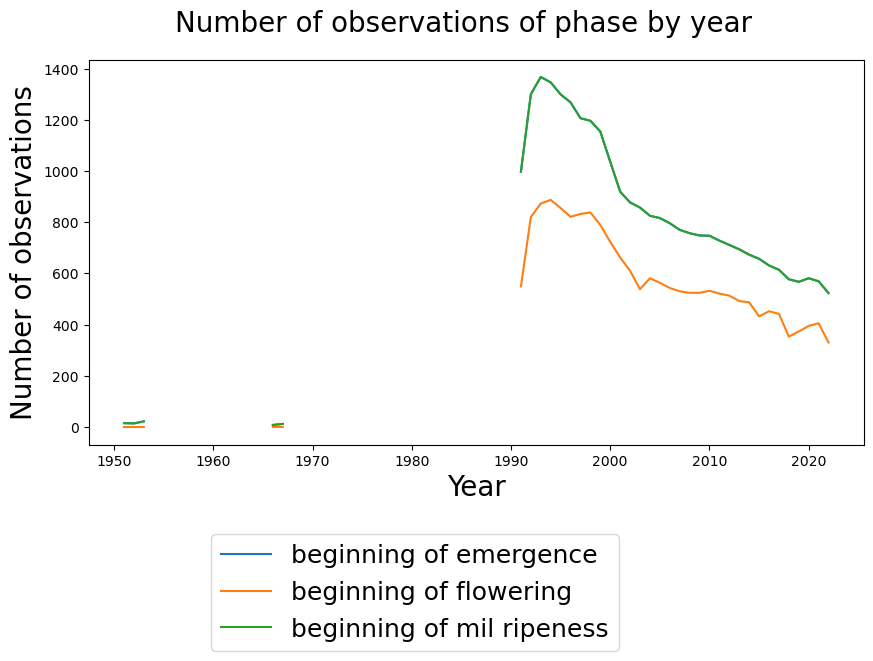

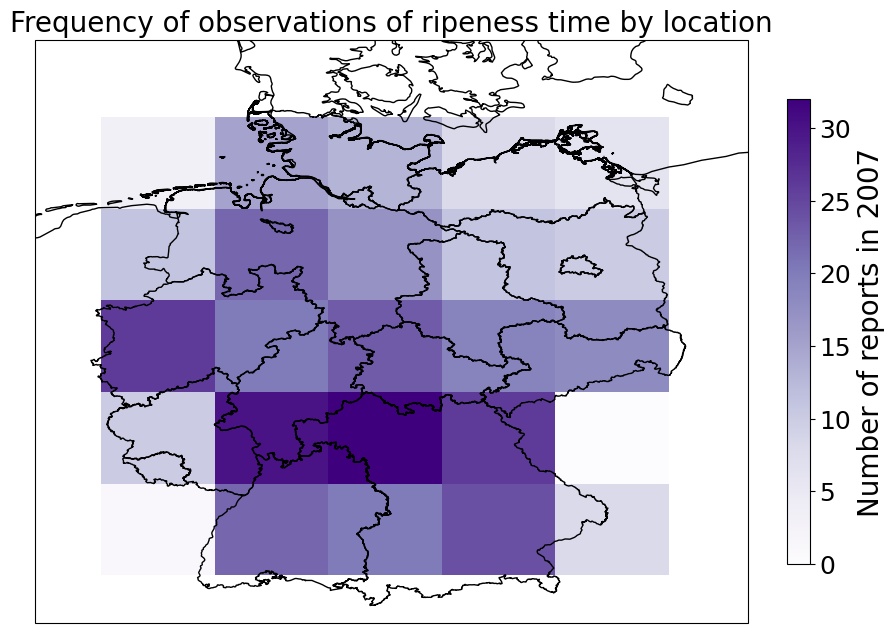

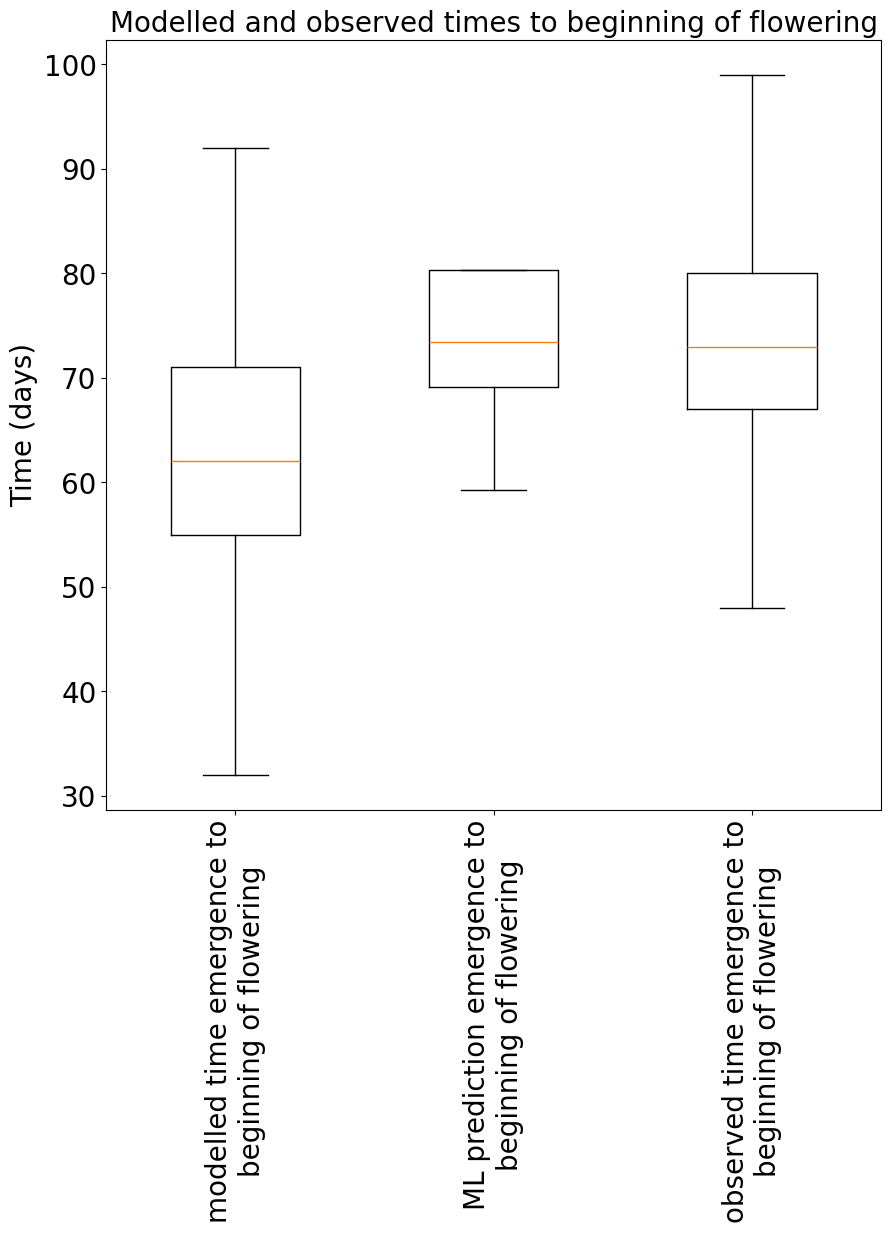

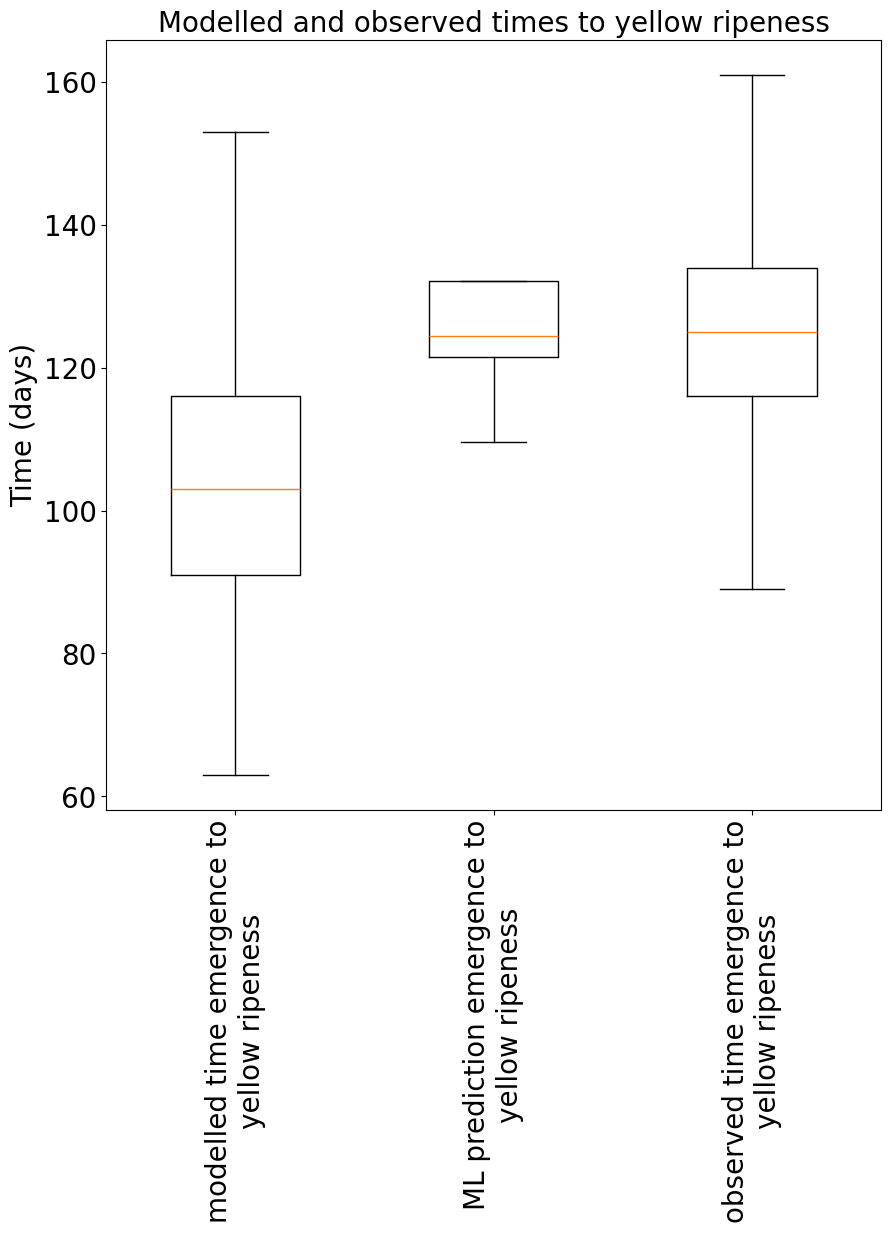

In [184]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [48]:
def plot_error_distn(ds, phases, training_means, font_size = 20):
    for phase_index, phase in enumerate(phases):
        fig, ax = plt.subplots(figsize = (10, 7))
        print(training_means[phase_index])
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ax.boxplot([model_residuals.dropna(), ML_residuals.dropna(), residuals_to_average.dropna()],
                   tick_labels=[f'residuals modelled\ntime', f'residuals ML\nprediction', f'obs - training mean'], #tick_labels=[f'residuals modelled time emergence\nto {phase}', f'residuals ML prediction emergence\nto {phase}', f'residuals compared to training mean\n{phase}'],
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 50)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'ML and model residuals,\ntime to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [25]:
def RMSE(residuals):
    return np.sqrt(np.mean(residuals**2))

In [182]:
def RMSE_ML_model(ds, phases, training_means):
    for phase_index, phase in enumerate(phases):
        print('Phase: ' + str(phase))
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ML_residuals = ML_residuals.where(np.abs(ML_residuals) < 60)
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        residuals_to_average = residuals_to_average.where(np.abs(model_residuals) < 60)
        print('RMSE for ML is ' + str(np.round(RMSE(ML_residuals), decimals=1)))
        print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        print('RMSE to training mean is ' + str(np.round(RMSE(residuals_to_average), decimals=1)))

In [35]:
training_means

[79.55844155844156, 133.06493506493507]

In [ ]:
def get_ML_dataset(self, phase_list = []):
    if len(phase_list) == 0:
        computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
    else:
        computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
        #Initialize dataset for comparison with station IDs and years
    data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                    'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                    }
    self.ds_comparison = pd.DataFrame(data_comparison)
    #Add modelled phase dates etc. to the comparison set.
    ML_e
    for phase_index, phase in enumerate(computed_phases):
        self.ds_comparison[phase] = self.ML_fit[phase_index, :]
    self.ds_comparison.set_index(['Referenzjahr', 'Stations_id'], inplace=True)

In [41]:
## Check that indexing is right
S = 7504
Y = 2005
print(ds['tas'].sel(Referenzjahr=Y, Stations_id = S).values, Maize_set.GDD_driver_data['tas'].sel(Referenzjahr=Y, Stations_id = S).values)
print(ds.sel(Referenzjahr=Y, Stations_id = S)['observed time emergence to beginning of flowering'].values, Maize_set.ds_observed.loc[(S, Y)]['observed time emergence to beginning of flowering'])

[-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684] [-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684]
100.0 100.0
